In [1]:
import sys
sys.path.append("../../analysis")

import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
from typing import Optional
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from classes import NFPO
from classes import NFPO_SOCP
from classes import NFPO_SDP
%matplotlib inline

rng = np.random.default_rng()

warnings.simplefilter('ignore')

## サンプル生成

In [2]:
tag_location = {
    "x": 1,
    "y": 1.5,
}
tag_population = 8
tags_number = np.arange(tag_population)
tags_space = 0.1
frequency_list = np.array([916.8e6, 918.0e6, 919.2e6, 920.4e6])
light_speed = 2.998e8
wave_length_list = [light_speed/frequency for frequency in frequency_list]
sample_count = 1000

### Phases

In [3]:
wave_length = wave_length_list[3]
R = np.sqrt((tag_location["x"]+tags_number*tags_space)**2 + tag_location["y"]**2)
phases = (
    np.tile(
        np.array(
            (
                -4
                * np.pi
                * R
                / wave_length
            )
        ),
        (sample_count, 1)
    ) 
    # + np.tile(
    #     np.array(
    #         [1 for i in range(tag_population)]
    #     ),
    #     (sample_count, 1)
    # )
    + rng.normal(loc=0.0, scale=0.1, size=(sample_count, tag_population))
) % (2 * np.pi)

print(np.mean(phases, axis=0))
print(np.std(phases, axis=0))

[5.85278721 3.63746265 1.29364287 5.09934355 2.52318453 5.79415482
 3.35027818 0.50022195]
[0.10165263 0.10114036 0.09842401 0.09834984 0.09615708 1.35032077
 0.10369552 0.10351764]


### RSSI

In [4]:
rssi = np.array([
        [
            (R[0] / r) ** 4
            # + np.random.normal(loc=0, scale=1 / 3)
            for r in R
        ]
    for i in range(sample_count)
])

# 混合整数非線形計画法


## 検証

In [5]:
nfpo = NFPO_SDP(
    sample_count=sample_count,
    tags_space=tags_space,
    phases=phases,
    tag_population=tag_population,
    wave_length = wave_length,
    tag_location = tag_location,
    initial_value = {"x":0, "y":1},
    y_err_range = 1,
    x_err_range = 2,
)
result = nfpo.solve(tee=True)
nfpo.del_component()
nfpo.renew_parameter()
print(f"Primal bound = {result["primal_bound"]}, Dual bound = {result["dual_bound"]}")
print(f"Solving time = {result["solving_time"]}[s]\nx = {result["values"]["x"]}[m]\ny = {result["values"]["y"]}[m]\nN = {result["values"]["N"]}")

SCIP version 9.1.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.1.0] [GitHash: 66f11a6724]
Copyright (c) 2002-2024 Zuse Institute Berlin (ZIB)

External libraries: 
  Readline 8.2         GNU library for command line editing (gnu.org/s/readline)
  Soplex 7.1.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 595bfac9]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.12          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.3.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB)
  Nauty 2.8.8          Computing Graph Automorphism Groups by Brendan D. McKay (users.cecs.an

## x軸方向制限範囲-探索時間

In [6]:
x_err_range_solving_time_list = []

for i in range(0, 101):
    x_err = i/100
    nfpo.renew_parameter(x_err_range=x_err)
    result = nfpo.solve()
    solving_time = result["solving_time"]
    values = result["values"]
    x_err_range_solving_time_list.append(solving_time)
    print(f"x_err = {x_err}[m], Solve time = {solving_time}[s], Values = {values}")
    nfpo.del_component()

# reset
nfpo.renew_parameter(x_err_range=0.3)

x_err = 0.0[m], Solve time = 1.15[s], Values = {'x': 1.0, 'y': 0.7245616041884178, 'N': [-14.0, -14.0, -14.0, -15.0, -15.0, -16.0, -16.0, -16.0]}
x_err = 0.01[m], Solve time = 1.34[s], Values = {'x': 0.9899999980399882, 'y': 0.8452082214737041, 'N': [-15.0, -15.0, -15.0, -16.0, -16.0, -17.0, -17.0, -17.0]}
x_err = 0.02[m], Solve time = 0.99[s], Values = {'x': 0.9799999980199998, 'y': 0.9505615042140341, 'N': [-16.0, -16.0, -16.0, -17.0, -17.0, -18.0, -18.0, -18.0]}
x_err = 0.03[m], Solve time = 0.96[s], Values = {'x': 0.9699999980881476, 'y': 1.2574055337031558, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
x_err = 0.04[m], Solve time = 0.91[s], Values = {'x': 0.9599999981166771, 'y': 1.2677604274984526, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
x_err = 0.05[m], Solve time = 1.33[s], Values = {'x': 0.9499999980000006, 'y': 1.4563778165633978, 'N': [-23.0, -23.0, -23.0, -24.0, -24.0, -25.0, -25.0, -25.0]}
x_err = 0.06[m], Solve time = 1.13[s], Value

## y軸方向制限範囲-探索時間

In [7]:
y_err_range_solving_time_list = []

for i in range(0, 101):
    y_err = i/100
    nfpo.renew_parameter(y_err_range=y_err)
    result = nfpo.solve()
    solving_time = result["solving_time"]
    values = result["values"]
    y_err_range_solving_time_list.append(solving_time)
    print(f"y_err = {y_err}[m], Solve time = {solving_time}[s], Values = {values}")
    nfpo.del_component()

# reset
nfpo.renew_parameter(x_err_range=0.3)

y_err = 0.0[m], Solve time = 0.32[s], Values = {'x': 0.6999999899999869, 'y': 1.5, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
y_err = 0.01[m], Solve time = 0.35[s], Values = {'x': 0.699999998685321, 'y': 1.4899999988115527, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
y_err = 0.02[m], Solve time = 0.38[s], Values = {'x': 0.699999998685321, 'y': 1.4854863692884925, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
y_err = 0.03[m], Solve time = 0.36[s], Values = {'x': 0.699999998685321, 'y': 1.4859155332893312, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
y_err = 0.04[m], Solve time = 0.4[s], Values = {'x': 0.699999998685321, 'y': 1.5396950800550675, 'N': [-21.0, -21.0, -21.0, -22.0, -22.0, -23.0, -23.0, -23.0]}
y_err = 0.05[m], Solve time = 0.42[s], Values = {'x': 0.699999998685321, 'y': 1.485807413099111, 'N': [-20.0, -20.0, -20.0, -21.0, -21.0, -22.0, -22.0, -22.0]}
y_err = 0.06[m], Solve time = 0.42[s], Values = {'x

## アンテナ間隔-探索時間

In [8]:
ant_space_solving_time_list = []

for i in range(50, 250):
    tags_space = i/1000
    nfpo.renew_parameter(tags_space=tags_space)
    result = nfpo.solve()
    solving_time = result["solving_time"]
    values = result["values"]
    ant_space_solving_time_list.append(solving_time)
    print(f"Antennas space = {i/1000}[m], Solve time = {solving_time}[s], Values = {values}")
    nfpo.del_component()

# reset
nfpo.renew_parameter(tags_space=0.1)

Antennas space = 0.05[m], Solve time = 1.36[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas space = 0.051[m], Solve time = 1.37[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas space = 0.052[m], Solve time = 1.46[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas space = 0.053[m], Solve time = 1.36[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas space = 0.054[m], Solve time = 1.37[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas space = 0.055[m], Solve time = 1.41[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Anten

## アンテナ数-探索時間

In [9]:
ant_pop_solving_time_list = []

for i in range(3, 15):
    nfpo.renew_parameter(tag_population=i)
    result = nfpo.solve()
    solving_time = result["solving_time"]
    values = result["values"]
    ant_pop_solving_time_list.append(solving_time)
    print(f"Antennas population = {i}, Solve time = {solving_time}[s], Values = {values}")
    nfpo.del_component()

# reset
nfpo.renew_parameter(tag_population=5)

Antennas population = 3, Solve time = 1.35[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas population = 4, Solve time = 1.35[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas population = 5, Solve time = 1.37[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas population = 6, Solve time = 1.47[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas population = 7, Solve time = 1.42[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas population = 8, Solve time = 1.44[s], Values = {'x': 0.7000000040039221, 'y': 0.502989425584015, 'N': [-8.0, -8.0, -8.0, -9.0, -9.0, -10.0, -10.0, -10.0]}
Antennas populat

### 可視化

Text(0.5, 1.0, 'antennas population to solve time')

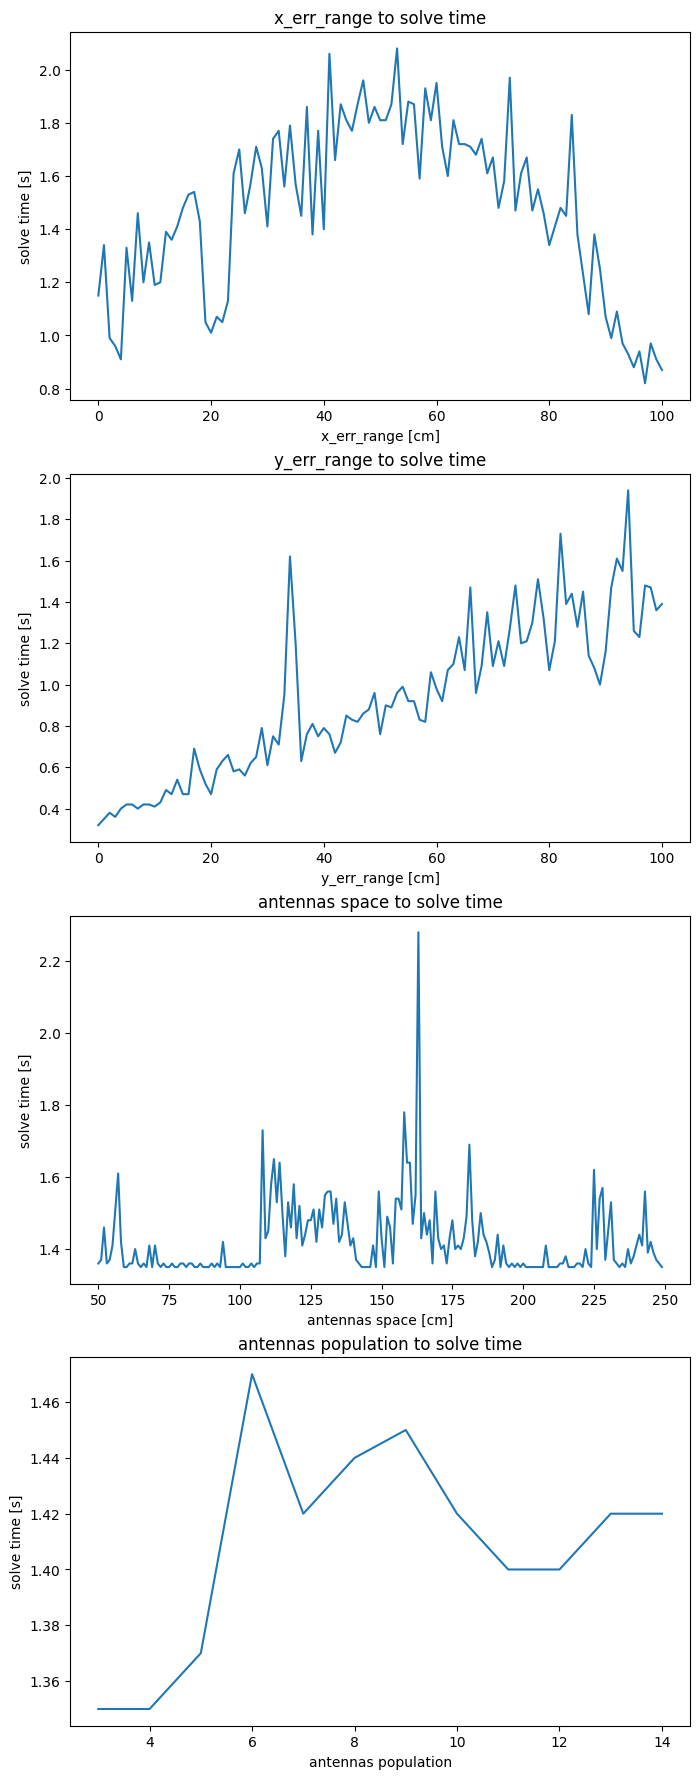

In [10]:
fig, axes = plt.subplots(4,1,figsize=(8,22))
axes[0].plot(list(range(0, 101)), x_err_range_solving_time_list)
axes[0].set_xlabel("x_err_range [cm]")
axes[0].set_ylabel("solve time [s]")
axes[0].set_title("x_err_range to solve time")
axes[1].plot(list(range(0, 101)), y_err_range_solving_time_list)
axes[1].set_xlabel("y_err_range [cm]")
axes[1].set_ylabel("solve time [s]")
axes[1].set_title("y_err_range to solve time")
axes[2].plot(list(range(50, 250)), ant_space_solving_time_list)
axes[2].set_xlabel("antennas space [cm]")
axes[2].set_ylabel("solve time [s]")
axes[2].set_title("antennas space to solve time")
axes[3].plot(list(range(3, 15)), ant_pop_solving_time_list)
axes[3].set_xlabel("antennas population")
axes[3].set_ylabel("solve time [s]")
axes[3].set_title("antennas population to solve time")